In [100]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

In [101]:
data = pd.read_csv("Airline_data.csv")
data

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0
5,1981,21,362,6033.0
6,1982,26,764,5877.0
7,1983,20,809,6223.0
8,1984,16,223,7433.0
9,1985,22,1066,7107.0


In [122]:
upper = 50
lower = 10

n_max = data['Miles flown [100 mln miles]'].max()
n_min = data['Miles flown [100 mln miles]'].min()

theta = (np.log(upper) - np.log(lower)) / (n_max - n_min)
alpha = np.log(lower) - theta * n_min

print(f"theta={theta}\nalpha={alpha}")

theta=0.00045082294465941176
alpha=0.5610560577747383


#### Prior predictive analysis

In [103]:
%%writefile model1.stan

generated quantities {
  real alpha = normal_rng(0.5610560577747383, 0.05);
  real theta = normal_rng(0.00045082294465941176, 0.00015);
  real n = normal_rng(0, 1);
  real lambda = exp(alpha+theta*n);
  int accidents = poisson_rng(lambda);
}

Overwriting model1.stan


In [104]:
# create Stan model object
model = CmdStanModel(stan_file="model1.stan")

R = 1000
sim = model.sample(iter_sampling=R,
                   iter_warmup=0,
                   chains=1,
                   fixed_param=True,
                   seed=1234,
                   refresh=R)


INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab5/model1.stan to exe file /root/Data_Analytics/lab5/model1
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab5/model1
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [105]:
import seaborn as sns
df = sim.draws_pd()
df

,lp__,accept_stat__,alpha,theta,n,lambda,accidents
0,0.0,0.0,0.562698,0.000498,0.536920,1.75587,1.0
1,0.0,0.0,0.546584,0.000400,-0.002657,1.72734,1.0
2,0.0,0.0,0.625845,0.000145,0.992504,1.87009,1.0
3,0.0,0.0,0.547144,0.000637,-1.007600,1.72720,1.0
4,0.0,0.0,0.590065,0.000410,2.847030,1.80621,0.0
...,...,...,...,...,...,...,...
995,0.0,0.0,0.593674,0.000562,-0.104082,1.81052,2.0
996,0.0,0.0,0.596161,0.000419,-0.420557,1.81482,0.0
997,0.0,0.0,0.509105,0.000492,-0.180206,1.66365,0.0
998,0.0,0.0,0.547262,0.000363,-1.634030,1.72749,2.0


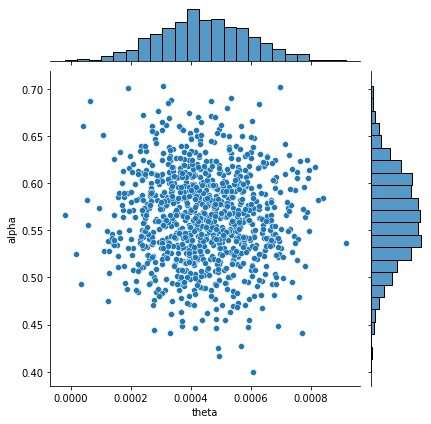

In [106]:
sns.jointplot(df, x='theta', y='alpha')
plt.show()

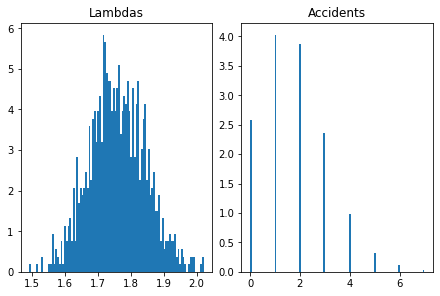

In [107]:
_, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].hist(df['lambda'], density=True, bins=100)
ax[0].set_title("Lambdas")
ax[1].hist(df['accidents'], density=True, bins=100)
ax[1].set_title("Accidents")
plt.show()

#### Fitting the model

In [123]:
%%writefile model2.stan

data {
  int<lower=1> N;
  vector[N] miles;
  int accidents[N];
}

parameters {
  real alpha;
  real theta;
}

transformed parameters {
  vector[N] lambda;
  lambda = exp(alpha + theta * miles);
}


model {
  alpha ~ normal(0.5610560577747383, 0.05);
  theta ~ normal(0.00045082294465941176, 0.00015);
  
  for (i in 1:N) {
    accidents[i] ~ poisson(lambda[i]);
  }
}

Overwriting model2.stan


In [124]:
# create Stan model object
model = CmdStanModel(stan_file="model2.stan")

R = 1000
fit = model.sample(data={'N': len(data), 'miles': data['Miles flown [100 mln miles]'], 'accidents': data['Fatal accidents']},
                   seed=1234)

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab5/model2.stan to exe file /root/Data_Analytics/lab5/model2
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab5/model2
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab5/model2.hpp /root/Data_Analytics/lab5/model2.stan
Warning in '/root/Data_Analytics/lab5/model2.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math


INFO:cmdstanpy:CmdStan done processing.


In [125]:
df = fit.draws_pd()
df

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],lambda[6],lambda[7],lambda[8],lambda[9],lambda[10]
0,481.165,0.825030,0.003971,7.0,243.0,0.0,-479.870,0.598627,0.000417,9.11720,10.9405,14.8167,17.9062,20.5748,22.5430,21.1227,24.4026,40.4258,35.2854
1,481.159,0.844277,0.003971,8.0,471.0,0.0,-479.438,0.630234,0.000413,9.25315,11.0825,14.9616,18.0458,20.7051,22.6642,21.2507,24.5135,40.3963,35.3097
2,481.192,0.839836,0.003971,8.0,415.0,0.0,-479.801,0.620990,0.000411,9.12016,10.9168,14.7234,17.7474,20.3536,22.2729,20.8882,24.0841,39.6236,34.6496
3,481.138,0.991872,0.003971,8.0,471.0,0.0,-480.948,0.608766,0.000419,9.28591,11.1532,15.1281,18.3003,21.0424,23.0661,21.6057,24.9789,41.4869,36.1865
4,480.124,0.678980,0.003971,7.0,147.0,0.0,-478.700,0.597615,0.000432,9.65704,11.6652,15.9732,19.4372,22.4469,24.6761,23.0667,26.7886,45.1996,39.2578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,480.926,0.990088,0.002823,2.0,3.0,0.0,-480.922,0.645146,0.000414,9.44102,11.3141,15.2893,18.4522,21.1809,23.1919,21.7408,25.0906,41.4145,36.1839
3996,481.003,0.925581,0.002823,9.0,639.0,0.0,-479.251,0.618747,0.000421,9.42590,11.3278,15.3793,18.6150,21.4135,23.4795,21.9884,25.4328,42.3066,36.8861
3997,481.014,0.984571,0.002823,2.0,3.0,0.0,-480.777,0.618717,0.000420,9.41902,11.3186,15.3648,18.5959,21.3903,23.4532,21.9644,25.4034,42.2485,36.8375
3998,481.169,0.997178,0.002823,2.0,3.0,0.0,-480.978,0.618700,0.000417,9.28856,11.1443,15.0885,18.2317,20.9461,22.9480,21.5034,24.8392,41.1303,35.9048


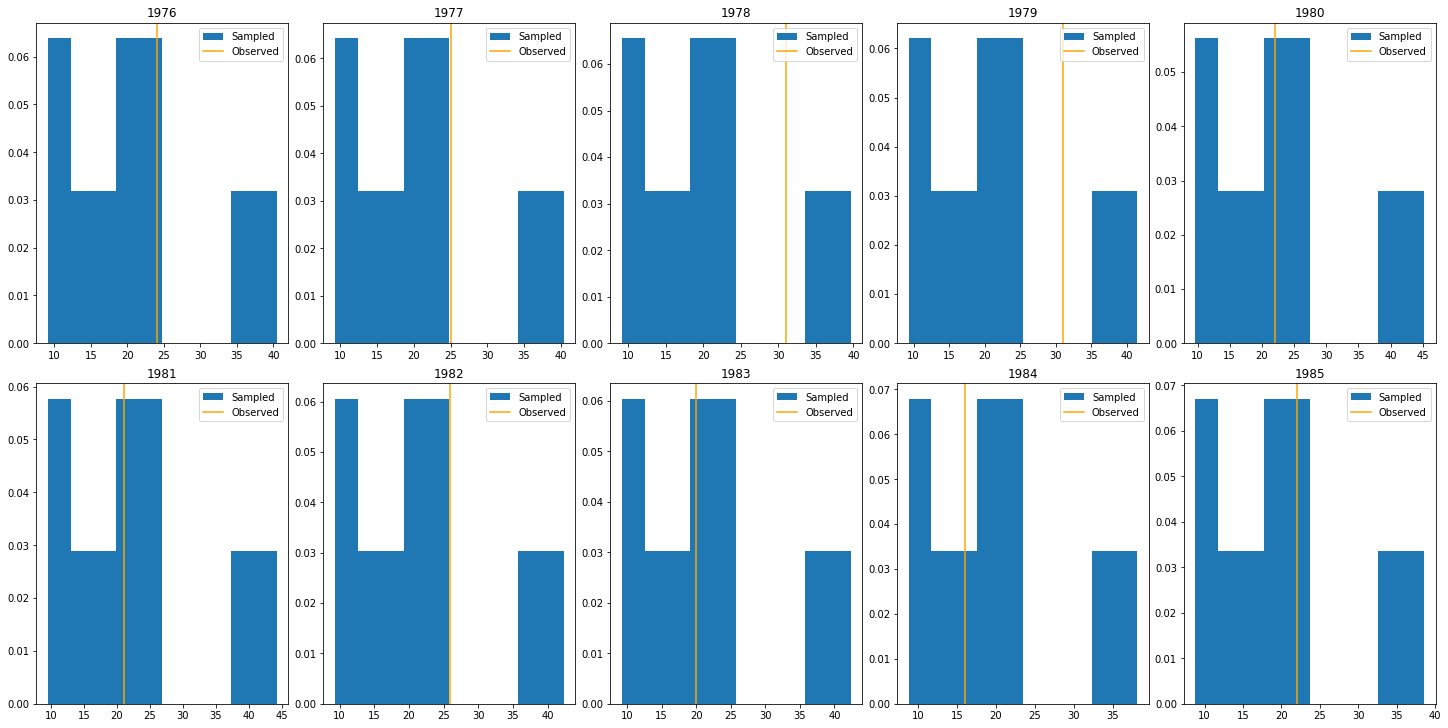

In [126]:
lambdas = df.loc[:, 'lambda[1]':].values

_, ax = plt.subplots(2, 5, constrained_layout=True, figsize=(20, 10))
for ax, sampled_lambda, observed_lambda, year in zip(ax.flatten(), lambdas, data['Fatal accidents'], data['Year']):
    ax.hist(sampled_lambda, density=True, label="Sampled")
    ax.axvline(observed_lambda, label="Observed", color='orange')
    ax.legend()
    ax.set_title(year)

plt.show()

#### Adding individual intercepts for each year

In [128]:
%%writefile model3.stan

data {
  int<lower=1> N;
  vector[N] miles;
  int accidents[N];
}

parameters {
  vector[N] alpha;
  real theta;
}

transformed parameters {
  vector[N] lambda;
  lambda = exp(alpha + theta * miles);
}


model {
  alpha ~ normal(0.5610560577747383, 0.05);
  theta ~ normal(0.00045082294465941176, 0.00015);
  
  for (i in 1:N) {
    accidents[i] ~ poisson(lambda[i]);
  }
}

Overwriting model3.stan


In [129]:
model = CmdStanModel(stan_file='model3.stan')
fit = model.sample(data={'N': len(data), 'miles': data['Miles flown [100 mln miles]'], 'accidents': data['Fatal accidents']},
                   seed=1234)

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab5/model3.stan to exe file /root/Data_Analytics/lab5/model3
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab5/model3
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab5/model3.hpp /root/Data_Analytics/lab5/model3.stan
Warning in '/root/Data_Analytics/lab5/model3.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math


INFO:cmdstanpy:CmdStan done processing.


In [130]:
df = fit.draws_pd()
df

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],lambda[6],lambda[7],lambda[8],lambda[9],lambda[10]
0,475.848,0.581261,0.003202,10.0,1023.0,0.0,-466.490,0.619017,0.605331,0.581241,...,10.47960,12.5724,16.9976,19.2094,24.2506,24.6531,24.7330,28.1156,48.9153,43.1660
1,477.721,0.884055,0.003202,10.0,1023.0,0.0,-470.945,0.559059,0.598422,0.603090,...,9.30481,11.6929,16.0902,20.7246,20.2792,24.3223,21.6237,26.0317,38.3118,34.4451
2,477.342,0.989175,0.003202,10.0,1023.0,0.0,-473.894,0.625604,0.565063,0.619814,...,9.41067,10.6349,15.2268,17.2958,22.0502,20.7929,22.1375,23.5119,39.7826,34.4902
3,478.234,0.996267,0.003202,10.0,1023.0,0.0,-473.264,0.596083,0.668128,0.607869,...,9.37255,12.1284,15.5529,17.2372,19.2964,22.2304,20.9428,23.4317,37.6544,35.6547
4,477.600,0.922209,0.003202,10.0,1023.0,0.0,-472.890,0.540045,0.506967,0.590850,...,9.38698,11.0064,16.4801,21.0220,22.6913,25.1173,22.1483,25.9850,44.7082,36.9051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,478.201,0.931443,0.003074,10.0,1023.0,0.0,-470.526,0.643362,0.581592,0.562121,...,9.83656,11.1359,14.8776,19.5100,21.8446,21.0839,20.9898,25.0730,37.7097,32.5430
3996,479.085,0.979368,0.003074,10.0,1023.0,0.0,-473.576,0.605266,0.585225,0.578281,...,9.32140,10.9828,14.8143,19.1198,20.6302,20.7618,20.5171,23.7326,36.4328,31.3284
3997,477.565,0.906108,0.003074,10.0,1023.0,0.0,-473.730,0.578818,0.652210,0.507668,...,8.62198,11.0888,12.9086,16.3658,19.3531,19.6873,18.6921,21.7256,34.7955,31.9570
3998,476.663,0.994143,0.003074,10.0,1023.0,0.0,-472.598,0.656620,0.616153,0.672085,...,10.49160,12.2036,17.7513,20.3546,22.0527,25.6279,25.5409,25.2961,43.4968,36.8419


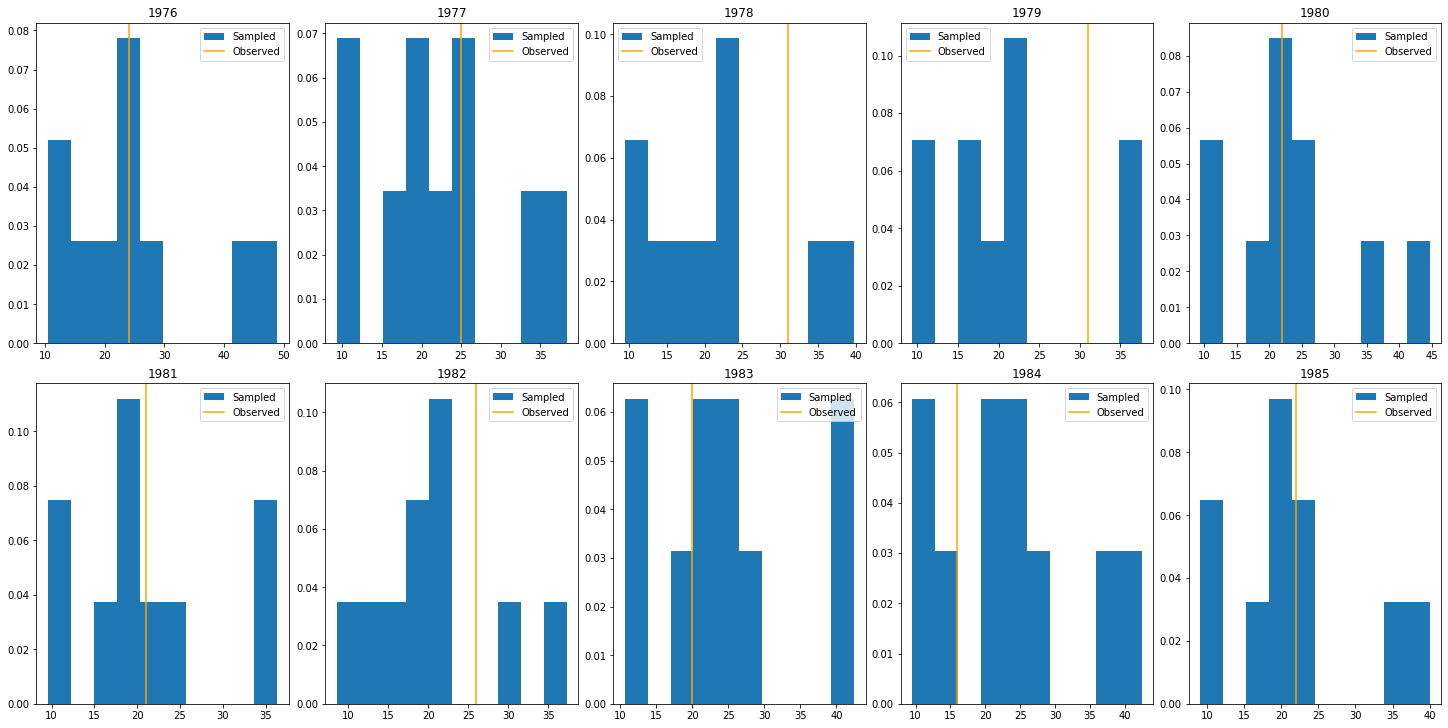

In [131]:
lambdas = df.loc[:, 'lambda[1]':].values

_, ax = plt.subplots(2, 5, constrained_layout=True, figsize=(20, 10))
for ax, sampled_lambda, observed_lambda, year in zip(ax.flatten(), lambdas, data['Fatal accidents'], data['Year']):
    ax.hist(sampled_lambda, density=True, label="Sampled")
    ax.axvline(observed_lambda, label="Observed", color='orange')
    ax.legend()
    ax.set_title(year)

plt.show()